# Chapter 2. Text Classification

This section explains the text classification task with a sentiment analysis over twitter dataset. Two different approaches are investigated: feature-based and fine-tuning a model. 
1. In feature based model, first the features are extracted from distil-bert, then used in a logistic regression model. 
   * (+) It is fast and can be run over CPU. 
   * (-) The result is acceptable but not enough. 

2. In fine-tuning model, the text data is directly fed to the pre-trained model and the model is then fine-tuned with this data. 
   * (+) The result is much better. 
   * (-) It is expensive and requires GPU. 



* [DistilBERT](https://arxiv.org/pdf/1910.01108v4.pdf): is a small and light version of BERT with less parameters. It is built based on knowledge distillation over BERT. With the similar architecture as BERT, the student architecture, DistilBERT,  contains less number or layers than BERT. It yields comparable results on downstream task. 

* How important [CLS]and [SEP] characters 
* UMAP algorithm

In [ ]:
!pip install transformers 
!pip install datasets 
!pip install pandas 
!pip3 install umap-learn
!pip install scikit-learn

In [ ]:
!pip install umap-learn

## Datasets 

* behaves like an ordinary Python array or list 

In [ ]:
from datasets import list_datasets 

all_datasets = list_datasets()

print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 20161 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
# Loading the emotion dataset 
from datasets import load_dataset

emotions = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
emotions 

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
# Only choosing one column for multiple examples 
print(train_ds['text'][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [ ]:
# changing format into pandas dataframe 
emotions.set_format(type="pandas")
df = emotions['train'][:]
df.head(2)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0


In [ ]:
# changing labels to string names 
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Understanding data 

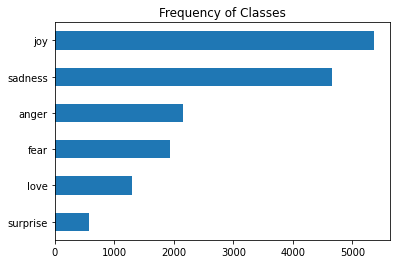

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


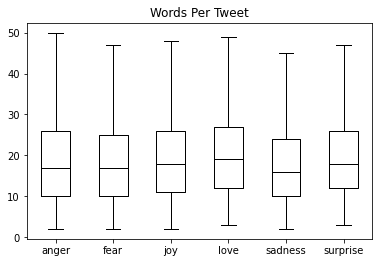

In [ ]:
# How long are the tweets?
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
emotions.reset_format()

## Tokenization 

* the step of breaking down a string into the atomic unites used by the model. 

* Character tokenization

   * (+) deals misspellings and rare words
   * (-) the linguistic structure is ignored. 


* Word tokenization 
   * (+) reduces the complexity of using characters. 
   * (-) punctuations are not accounter.  
   * (-) the size of vocabulary grows easily. 


* Sub-word 

**1. Character Tokenization**

In [ ]:
# Simple character tokenization 
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)
# Encoding each token as integer
# Get the mapping 
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)
# Encode the text to obtain input ids 
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}
[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [ ]:
# creating one-hot vector from input_ids 
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
# num_classes: the number of unique characters in the vocabulary
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

Here, for each input token we have a one-hot vector with 20 dimensions, because our vocabulary contains 20 distinct characters. 

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


**2. Word Tokenization**

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


**3. Subword Tokenization**

? Used subword tokenization algorithms. 

? WordPiece 

In [ ]:
# Loading the tokenizer related to the model 
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
# Encoding 
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# Decoding 
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [ ]:
# Total number of subwords in the vocabulary 
tokenizer.vocab_size

30522

In [ ]:
# Maximum length 
tokenizer.model_max_length

512

In [ ]:
# What fields model require? 
tokenizer.model_input_names

['input_ids', 'attention_mask']

**Tokenizing the whole dataset**

* `map():` applies a processing function to each element in the dataset. 

* `attention_mask `: indicates where to ingore (0) as padding. 



In [ ]:
# First define the processing function 
def tokenize(batch):
    """ pads the examples to the longest one in the batch"""
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
""" applying the function across the dataset
 batched: Set True, if the tokenization is applied by batch 
 batch_size: int, the number of batch 
   since batch_size=None, the tokenization and padding will be applied globally.  
"""
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


In [ ]:
emotions_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

## Training a Text Classifier 

In LM model:
1. The text is tokenized and represented by one-hot vectors as token encodings.
2. The token encodings are converted to the token embeddings.
3. The token embeddings are fed to the encoder. 
4. The hidden states for each input token are generated from the encoders.
5. Each hidden state is fed to a layer to predict masked token. 

In classification, the last layer (step 5) is replaced by a classification layer. 

Two approaches to train the model: 





 ### 1. **Feature extraction:** 
 It is training a classifier on hidden states without modyfying the pre-trained model. 

  * Freeze the models weights during training and use the hidden states as features. 
  * (+) fast and not expensive 


In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


*The `AutoModel` converts the token encoddings to embeddings and then feeds them through the encoder to get the hidden states.*

In [ ]:
# hidden states for one string 
# First encode the string and return as Tensor 
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
# The resulting string has shape: [batch_size, n_tokens]
# Second, get the states 
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)
print(outputs['last_hidden_state'].shape)

Input tensor shape: torch.Size([1, 6])
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)
torch.Size([1, 6, 768])


The last hidden state has shape [`batch_size, n_tokens, hidden_dim]`, meaning that for each token we have 768-dim vector. 

Note that the tokenization step adds start and end tokens to the sequence.

In [ ]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
# Now get the hidden states for all dataset 
def extract_hidden_states(batch):
    # Place model inputs on the GPU/CPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
# Model expects tensors as inputs
# converting the inputs to tensors 
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Now get the states for all 
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)


In [ ]:
# extract_hidden_state function added a new column to the dataset
# named hidden_state 
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

**Creating a feature matrix**

The dataset contains all the necessary information to train a classifier.
* hidden_states: are the input features 
* labels: are the targets 


In [ ]:
# Creating arrays using numpy 
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
# Training a logistic regression with the features 
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
# To compare the result 
# we create a dummyclassifier 
# that chooses always the most frequent 
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

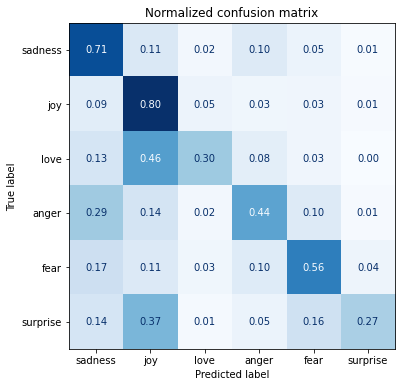

In [ ]:
# Looking the confusion matrix 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


### 2. Fine-tuning: training the whole model.

We will update the hidden states using the dataset. 

In [ ]:
# Model is loaded with specific class for the task 
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [ ]:
# Defining the metric used during training 
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [ ]:
# Defining training arguments 
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.822400,0.323462,0.904500,0.900422
2,0.255500,0.224372,0.925000,0.924878


TrainOutput(global_step=500, training_loss=0.5389707260131836, metrics={'train_runtime': 244.6833, 'train_samples_per_second': 130.781, 'train_steps_per_second': 2.043, 'total_flos': 720342861696000.0, 'train_loss': 0.5389707260131836, 'epoch': 2.0})

In [ ]:
# Get the confusion matrix 
# First get the predictions 
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.22437240183353424,
 'test_accuracy': 0.925,
 'test_f1': 0.9248782843842599,
 'test_runtime': 4.2981,
 'test_samples_per_second': 465.322,
 'test_steps_per_second': 7.445}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

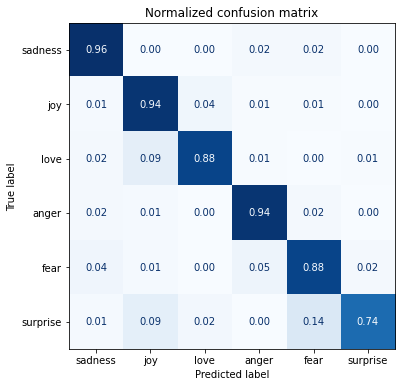

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)


**Error Analysis**



In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Getting the losses over each sample 
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
# List the samples by their loss
df_test.sort_values("loss", ascending=False).head(10)


,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.517489
882,i feel badly about reneging on my commitment t...,love,sadness,5.372984
1111,im lazy my characters fall into categories of ...,joy,fear,5.355901
465,i would eventually go in to these stores but i...,joy,fear,5.185845
1950,i as representative of everything thats wrong ...,surprise,sadness,5.104771
1274,i am going to several holiday parties and i ca...,joy,sadness,5.011372
1509,i guess this is a memoir so it feels like that...,joy,fear,4.968413
1963,i called myself pro life and voted for perry w...,joy,sadness,4.884280
765,i feel super awkward and out of place right now,joy,sadness,4.689157
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.681523


In [ ]:
# List the examples which have the lowest losses
df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017803
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.018053
1965,i started feeling pathetic and ashamed,sadness,sadness,0.018364
1303,i feel pathetic and uninspired,sadness,sadness,0.018378
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.018518
726,i feel too energetic and some days i just feel...,joy,joy,0.018530
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.018530
1320,im feeling positive but its impossible to desc...,joy,joy,0.018626
19,i had lunch with an old friend and it was nice...,joy,joy,0.018813
396,i feel pretty pathetic now,sadness,sadness,0.018822


## Uploading to the Hub 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# trainer.push_to_hub(commit_message="Training completed!")

## Visualizing the hidden states

In this section, the visualization works on the array obtained from features in Section **Feature Extraction. **

The features will be visualized using UMAP which works best when the features are scaled [0,1]. 


In [ ]:
#import umap.umap_ as UMAP
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd 
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.219185,6.574882,0
1,-2.965774,5.468565,0
2,5.448373,3.229575,3
3,-2.057950,3.284717,2
4,-3.118060,3.346772,3


Now, in the dataframe we have the same number of examples as training data with 2-dimensions.

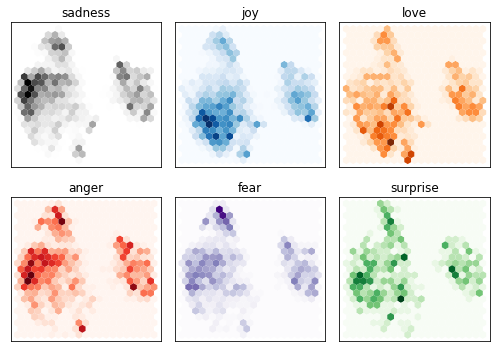

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()
